# Analyse results
Here we will analyze the first results of the experiments

## Data Loading
We load the data and merge the  different files. Furthermore, we rename the variables for ansatz, optimizer and featuremap to make the more user friendly.


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 

from scipy.stats import friedmanchisquare,  wilcoxon, kruskal, mannwhitneyu

sns.set(font_scale=1.25)
sns.set(style='white', palette=None)

In [2]:
declare = True
res = []

for noise, noise_string in zip(['none', 'ibm_perth'], ['_', 'ibm_perth']):
    for init in ['uniform', 'beta', 'normal']:
        res_current = []
        for optimizer in ['cobyla', 'spsa', 'neldermead']:
            for preprocessing in ['pca', 'lda']:
                res_current.append(pd.read_csv('../reports/results/kdd_' + noise_string + '_' + optimizer + '_' + preprocessing + "_" + init + "_" + 'results.csv', index_col=0))
        res_current = pd.concat(res_current)
        res_current['noise'] = noise
        res_current['initialization'] = init
        res.append(res_current)
res = pd.concat(res)
res.head()

,accuracy,f1,time,ansatz,optimizer,featuremap,entanglement,entanglement_featuremap,iterations,preprocessing,noise,initialization
20,0.840,0.842216,3292.493901,<function get_efficientsu2 at 0x7feaebaef790>,<function get_cobyla at 0x7feaebaef820>,<function get_zfeaturemap at 0x7feaf26b6d30>,full,NaN,500,pca,none,uniform
21,0.872,0.872416,2144.180177,<function get_efficientsu2 at 0x7feaebaef790>,<function get_cobyla at 0x7feaebaef820>,<function get_zfeaturemap at 0x7feaf26b6d30>,linear,NaN,373,pca,none,uniform
22,0.904,0.897542,2906.822477,<function get_efficientsu2 at 0x7feaebaef790>,<function get_cobyla at 0x7feaebaef820>,<function get_zfeaturemap at 0x7feaf26b6d30>,circular,NaN,500,pca,none,uniform
23,0.880,0.886025,2457.676658,<function get_efficientsu2 at 0x7feaebaef790>,<function get_cobyla at 0x7feaebaef820>,<function get_zfeaturemap at 0x7feaf26b6d30>,sca,NaN,436,pca,none,uniform
24,0.648,0.642881,4182.781687,<function get_efficientsu2 at 0x7feaebaef790>,<function get_cobyla at 0x7feaebaef820>,<function get_zzfeaturemap at 0x7feaf26b6dc0>,full,full,413,pca,none,uniform


In [3]:
# if ansatz contains 'efficientsu2' replace with 'efficient_su2'
res['ansatz'] = res['ansatz'].apply(lambda x: 'efficient_su2' if 'efficientsu2' in x else x)
# if ansatz = 'paulitwodesign' replace with 'pauli_two_design'
res['ansatz'] = res['ansatz'].apply(lambda x: 'pauli_two_design' if 'paulitwodesign' in x else x)
# if ansatz = 'realamplitudes' replace with 'real_amplitudes'
res['ansatz'] = res['ansatz'].apply(lambda x: 'real_amplitudes' if 'realamplitudes' in x else x)
# if ansatz = 'twolocal' replace with 'two_local'
res['ansatz'] = res['ansatz'].apply(lambda x: 'two_local' if 'twolocal' in x else x)
# otherwise drop
res = res[res['ansatz'].isin(['efficient_su2', 'pauli_two_design', 'real_amplitudes', 'two_local'])]

In [4]:
# if optimizer contains 'cobyla' replace with 'cobyla'
res['optimizer'] = res['optimizer'].apply(lambda x: 'cobyla' if 'cobyla' in x else x)
# if optimizer = 'lbfgsb' replace with 'l_bfgs_b'
res['optimizer'] = res['optimizer'].apply(lambda x: 'spsa' if 'spsa' in x else x)
# if optimizer = 'neldermead' replace with 'nelder_mead'
res['optimizer'] = res['optimizer'].apply(lambda x: 'nelder_mead' if 'neldermead' in x else x)

In [5]:
# if feature_map contains 'pauli' replace with 'pauli'
res['featuremap'] = res['featuremap'].apply(lambda x: 'pauli' if 'pauli' in x else x)
# if feature_map = 'ZZFeatureMap' replace with 'zz'
res['featuremap'] = res['featuremap'].apply(lambda x: 'zz' if 'zzfeaturemap' in x else x)
# if feature_map = 'ZFeatureMap' replace with 'z'
res['featuremap'] = res['featuremap'].apply(lambda x: 'z' if 'zfeaturemap' in x else x)

In [6]:
index = ['ansatz', 'featuremap', 'entanglement', 'entanglement_featuremap', 'preprocessing', 'optimizer', 'initialization']

best_configs = res[res['accuracy'] > max(res['accuracy']) - 0.1]
worst_configs = res[res['accuracy'] < min(res['accuracy']) + 0.1]

In [7]:
# get absolute difference between noise and no noise
noise = res[res['noise'] == 'ibm_perth'].set_index(index).sort_index()
no_noise = res[res['noise'] == 'none'].set_index(index).sort_index()
diff = np.abs(noise['accuracy'] - no_noise['accuracy'])

In [8]:
most_similar = diff[diff < min(diff) + 0.05].reset_index()
least_similar = diff[diff > max(diff) - 0.05].reset_index()

In [9]:
print("Mean difference between noise and no noise: ", diff.mean())
print("Standard deviation of difference between noise and no noise: ", diff.std())

Mean difference between noise and no noise:  0.10170370370370369
Standard deviation of difference between noise and no noise:  0.11483837017118147


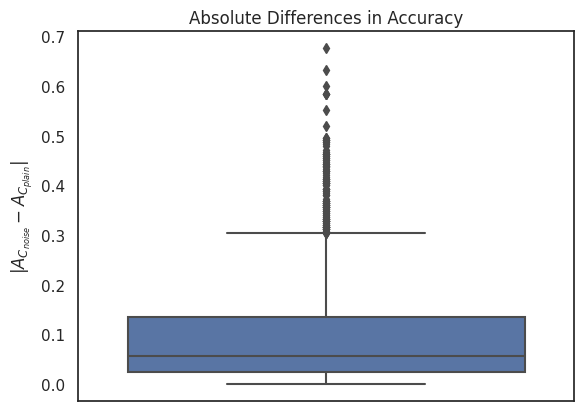

In [10]:
sns.boxplot(diff, palette='deep')
# name x tick of box plot
plt.xticks([0], [''])
plt.ylabel(r'$|{A}_{C_{noise}} - {A}_{C_{plain}}|$')
plt.title('Absolute Differences in Accuracy')
plt.savefig("../reports/figures/kdd_abs_diff.png")
plt.show()

In [11]:
print("Min difference between noise and no noise: ", diff.min())
print("Max difference between noise and no noise: ", diff.max())

Min difference between noise and no noise:  0.0
Max difference between noise and no noise:  0.676


In [12]:
print("Results with noise significantly worse ", wilcoxon(noise['accuracy'], no_noise['accuracy'], alternative='less').pvalue < 0.05)

Results with noise significantly worse  True


## Optimizer
We first consider the optimizer.
* All in all, NelderMead by far the worst
* COBYLA and Nelder-Mead with an without noise significantly different
* Interestingly, SPSA make up the biggest part of the least similar configurations

In [13]:
res.groupby(['optimizer', 'noise']).agg({"accuracy":[np.mean, np.median, np.std], "f1":[np.mean, np.median, np.std]})

accuracy                         f1                    
                           mean median       std      mean    median       std
optimizer   noise                                                             
cobyla      ibm_perth  0.662603  0.656  0.096069  0.668153  0.653120  0.091709
            none       0.736214  0.700  0.127932  0.736128  0.707430  0.127190
nelder_mead ibm_perth  0.164619  0.124  0.126333  0.180760  0.119967  0.145232
            none       0.191603  0.116  0.188407  0.202389  0.119333  0.196790
spsa        ibm_perth  0.660460  0.644  0.088977  0.664671  0.650850  0.090062
            none       0.725183  0.682  0.123890  0.724119  0.687610  0.124523

In [14]:
c = res[res['optimizer'] == 'cobyla'].set_index(index).sort_index()
n = res[res['optimizer'] == 'nelder_mead'].set_index(index).sort_index()
s = res[res['optimizer'] == 'spsa'].set_index(index).sort_index()

In [15]:
# Wilcoxon
print("Wilcoxon: Cobyla without noise significantly better:", wilcoxon(c.loc[c['noise'] == 'none','accuracy'].sort_index(), c.loc[c['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)
print("Wilcoxon: SPSA without noise significantly better",  wilcoxon(s.loc[s['noise'] == 'none','accuracy'].sort_index(), s.loc[s['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)
print("Wilcoxon: Nelder Mead without noise significantly better:",  wilcoxon(n.loc[n['noise'] == 'none','accuracy'].sort_index(), n.loc[n['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)

Wilcoxon: Cobyla without noise significantly better: True
Wilcoxon: SPSA without noise significantly better True
Wilcoxon: Nelder Mead without noise significantly better: False


In [16]:
# sort by performance
res = res.sort_values(by=['f1', 'accuracy'], ascending=False).reset_index(drop=True)
res.head()

,accuracy,f1,time,ansatz,optimizer,featuremap,entanglement,entanglement_featuremap,iterations,preprocessing,noise,initialization
0,0.972,0.965539,3848.459160,efficient_su2,spsa,zz,sca,sca,551,lda,none,beta
1,0.968,0.961857,3740.647303,efficient_su2,spsa,zz,sca,linear,551,lda,none,beta
2,0.964,0.960023,3413.893872,efficient_su2,cobyla,zz,sca,circular,500,lda,none,beta
3,0.964,0.959613,3022.445863,efficient_su2,cobyla,zz,sca,pairwise,450,lda,none,beta
4,0.972,0.958573,2598.325508,real_amplitudes,spsa,z,circular,NaN,551,lda,none,beta


In [17]:
most_similar.value_counts(['optimizer'])/res.value_counts(['optimizer'])

optimizer  
cobyla         0.243056
nelder_mead    0.222222
spsa           0.253968
Name: count, dtype: float64

In [18]:
least_similar.value_counts(['optimizer'])/res.value_counts(['optimizer'])

optimizer  
cobyla              NaN
nelder_mead    0.001984
spsa                NaN
Name: count, dtype: float64

## Ansatz
We now consider the ansatz parameter alone.
* All ansatzes, except PauliTwoDesign, perform signficantly different with and without noise
* None of the Pauli configurations are among the least similar ones
* Other than that, comparable ratios in the most similar ones

In [19]:
res.groupby(['ansatz', 'noise']).agg({"accuracy":[np.mean, np.std], "f1":[np.mean, np.std]})

accuracy                  f1          
                                mean       std      mean       std
ansatz           noise                                            
efficient_su2    ibm_perth  0.494667  0.259810  0.503238  0.258457
                 none       0.554259  0.303772  0.557712  0.301314
pauli_two_design ibm_perth  0.492074  0.241720  0.504218  0.239126
                 none       0.536630  0.287542  0.541780  0.284246
real_amplitudes  ibm_perth  0.495343  0.260585  0.503791  0.259084
                 none       0.557046  0.289436  0.560778  0.285638
two_local        ibm_perth  0.498081  0.254834  0.506212  0.252369
                 none       0.546430  0.294380  0.548646  0.292235

In [20]:
e = res[res['ansatz'] == 'efficient_su2'].set_index(index)
p = res[res['ansatz'] == 'pauli_two_design'].set_index(index)
r = res[res['ansatz'] == 'real_amplitudes'].set_index(index)
t = res[res['ansatz'] == 'two_local'].set_index(index)

In [21]:
# Wilcoxon
print("Wilcoxon: EfficientSU2 without noise significantly better", wilcoxon(e.loc[e['noise'] == 'none','accuracy'], e.loc[e['noise'] != 'none', 'accuracy'], alternative='greater').pvalue < 0.05)
print("Wilcoxon: PauliTwoDesign without noise significantly better:",  wilcoxon(s.loc[s['noise'] == 'none','accuracy'], s.loc[s['noise'] != 'none', 'accuracy'], alternative='greater').pvalue < 0.05)
print("Wilcoxon: RealAmplitudes without noise significantly better:",  wilcoxon(r.loc[r['noise'] == 'none','accuracy'], r.loc[r['noise'] != 'none', 'accuracy'], alternative='greater').pvalue < 0.05)
print("Wilcoxon: TwoLocal without noise significantly better:",  wilcoxon(t.loc[t['noise'] == 'none','accuracy'], t.loc[t['noise'] != 'none', 'accuracy'], alternative='greater').pvalue < 0.05)

Wilcoxon: EfficientSU2 without noise significantly better True
Wilcoxon: PauliTwoDesign without noise significantly better: True
Wilcoxon: RealAmplitudes without noise significantly better: True
Wilcoxon: TwoLocal without noise significantly better: True


In [22]:
most_similar.value_counts(['ansatz'])/res.value_counts(['ansatz'])

ansatz          
efficient_su2       0.237269
pauli_two_design    0.254630
real_amplitudes     0.240741
two_local           0.237963
Name: count, dtype: float64

In [23]:
least_similar.value_counts(['ansatz'])/res.value_counts(['ansatz'])

ansatz          
efficient_su2            NaN
pauli_two_design         NaN
real_amplitudes     0.002315
two_local                NaN
Name: count, dtype: float64

## Ansatz Entanglement
* Circular, full and linear entanglement with and without noise are significantly different
* Does not apply for pairwise and sca
* Still, no full configurations are among the least similar ones
* Pairwise has the biggest ratio among the least similar configs

In [24]:
res.groupby(['entanglement', 'noise']).agg({"accuracy": [np.mean, np.median, np.std], "f1": [np.mean, np.median, np.std]})

accuracy                         f1             
                            mean median       std      mean    median   
entanglement noise                                                      
circular     ibm_perth  0.489531  0.604  0.254347  0.499869  0.613287  \
             none       0.540827  0.624  0.303994  0.543962  0.634538   
full         ibm_perth  0.487580  0.604  0.256043  0.491017  0.614918   
             none       0.534667  0.630  0.306785  0.535223  0.633189   
linear       ibm_perth  0.497630  0.612  0.278572  0.500359  0.622092   
             none       0.548728  0.624  0.299877  0.550324  0.631005   
pairwise     ibm_perth  0.502481  0.608  0.251587  0.511493  0.612182   
             none       0.544630  0.636  0.303238  0.550462  0.638762   
sca          ibm_perth  0.507914  0.610  0.244879  0.524650  0.619333   
             none       0.586691  0.626  0.266534  0.592735  0.626209   

                                  
                             std  
entanglement noise                
circular     ibm_perth  0.255642  
             none       0.301642  
full         ibm_perth  0.254871  
             none       0.305950  
linear       ibm_perth  0.278951  
             none       0.297952  
pairwise     ibm_perth  0.247189  
             none       0.294862  
sca          ibm_perth  0.236604  
             none       0.261742

In [25]:
c = res[res['entanglement'] == 'circular'].set_index(index)
f = res[res['entanglement'] == 'full'].set_index(index)
l = res[res['entanglement'] == 'linear'].set_index(index)
p = res[res['entanglement'] == 'pairwise'].set_index(index)
s = res[res['entanglement'] == 'sca'].set_index(index)

In [26]:
# Wilcoxon
print("Wilcoxon: Circular without noise significantly better:", wilcoxon(c.loc[c['noise'] == 'none','accuracy'].sort_index(), c.loc[c['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)
print("Wilcoxon: Full without noise significantly different:",  wilcoxon(f.loc[f['noise'] == 'none','accuracy'].sort_index(), f.loc[f['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
print("Wilcoxon: Linear with noise significantly better:",  wilcoxon(l.loc[l['noise'] == 'none','accuracy'].sort_index(), l.loc[l['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)
print("Wilcoxon: Pairwise without noise significantly better:",  wilcoxon(p.loc[p['noise'] == 'none','accuracy'].sort_index(), p.loc[p['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)
print("Wilcoxon: Sca without noise significantly better:",  wilcoxon(s.loc[s['noise'] == 'none','accuracy'].sort_index(), s.loc[s['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)

Wilcoxon: Circular without noise significantly better: True
Wilcoxon: Full without noise significantly different: True
Wilcoxon: Linear with noise significantly better: True
Wilcoxon: Pairwise without noise significantly better: True
Wilcoxon: Sca without noise significantly better: True


In [27]:
most_similar.value_counts(['entanglement'])/res.value_counts(['entanglement'])

entanglement
circular        0.217593
full            0.251543
linear          0.268519
pairwise        0.217593
sca             0.223765
Name: count, dtype: float64

In [28]:
least_similar.value_counts(['entanglement'])/res.value_counts(['entanglement'])

entanglement
circular             NaN
full                 NaN
linear               NaN
pairwise             NaN
sca             0.003086
Name: count, dtype: float64

## Ansatz combined with ansatz entanglement
* RealAmplitudes full is significantly different
* TwoLocal linear is significantly different
* No clear patterns alltogether

In [29]:
res.groupby(['ansatz', 'entanglement', 'noise']).agg({"accuracy": [np.mean, np.median, np.std], "f1": [np.mean, np.median, np.std]})

accuracy                         f1   
                                            mean median       std      mean   
ansatz          entanglement noise                                            
efficient_su2   circular     ibm_perth  0.487407  0.602  0.254041  0.496522  \
                             none       0.547556  0.624  0.309143  0.550285   
                full         ibm_perth  0.485111  0.606  0.260885  0.492400   
                             none       0.539407  0.616  0.313333  0.542903   
                linear       ibm_perth  0.501667  0.620  0.283107  0.502389   
                             none       0.545370  0.636  0.311764  0.546779   
                sca          ibm_perth  0.504481  0.608  0.242604  0.521643   
                             none       0.584704  0.628  0.281902  0.590881   
real_amplitudes circular     ibm_perth  0.493630  0.604  0.255155  0.506143   
                             none       0.545370  0.636  0.307761  0.549455   
                full         ibm_perth  0.491444  0.604  0.251968  0.493674   
                             none       0.535778  0.636  0.302425  0.537550   
                linear       ibm_perth  0.500667  0.614  0.287641  0.503373   
                             none       0.562926  0.622  0.284589  0.564621   
                sca          ibm_perth  0.495630  0.604  0.249290  0.511975   
                             none       0.584111  0.628  0.262497  0.591485   
two_local       circular     ibm_perth  0.487556  0.604  0.256163  0.496941   
                             none       0.529556  0.612  0.297462  0.532147   
                full         ibm_perth  0.486185  0.602  0.257540  0.486976   
                             none       0.528815  0.626  0.307268  0.525214   
                linear       ibm_perth  0.490556  0.602  0.267011  0.495317   
                             none       0.537889  0.616  0.304857  0.539571   
                pairwise     ibm_perth  0.502481  0.608  0.251587  0.511493   
                             none       0.544630  0.636  0.303238  0.550462   
                sca          ibm_perth  0.523630  0.616  0.244135  0.540332   
                             none       0.591259  0.616  0.256991  0.595838   

                                                            
                                          median       std  
ansatz          entanglement noise                          
efficient_su2   circular     ibm_perth  0.615312  0.254988  
                             none       0.635961  0.307424  
                full         ibm_perth  0.613059  0.257149  
                             none       0.630138  0.311395  
                linear       ibm_perth  0.630922  0.285110  
                             none       0.632980  0.311754  
                sca          ibm_perth  0.618835  0.236925  
                             none       0.615031  0.274831  
real_amplitudes circular     ibm_perth  0.601591  0.255485  
                             none       0.641175  0.306204  
                full         ibm_perth  0.605617  0.253114  
                             none       0.634854  0.300211  
                linear       ibm_perth  0.625563  0.287677  
                             none       0.630016  0.279077  
                sca          ibm_perth  0.615979  0.241053  
                             none       0.632510  0.255406  
two_local       circular     ibm_perth  0.615824  0.258707  
                             none       0.624282  0.293569  
                full         ibm_perth  0.618223  0.256659  
                             none       0.634059  0.308717  
                linear       ibm_perth  0.606886  0.266104  
                             none       0.627670  0.304262  
                pairwise     ibm_perth  0.612182  0.247189  
                             none       0.638762  0.294862  
                sca          ibm_perth  0.621741  0.233092  
                             none       

In [30]:
for ansatz in ['efficient_su2', 'real_amplitudes', 'two_local']:
    e = res[res['ansatz']==ansatz]
    e_c = e[e['entanglement'] == 'circular'].set_index(index)
    e_f = e[e['entanglement'] == 'full'].set_index(index)
    e_l = e[e['entanglement'] == 'linear'].set_index(index)
    e_s = e[e['entanglement'] == 'sca'].set_index(index)

    # Wilcoxon
    print(ansatz, "Wilcoxon: Circular with and without noise significantly different:", wilcoxon(e_c.loc[e_c['noise'] == 'none','accuracy'].sort_index(), e_c.loc[e_c['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
    print(ansatz, "Wilcoxon: Full with and without noise significantly different:",  wilcoxon(e_f.loc[e_f['noise'] == 'none','accuracy'].sort_index(), e_f.loc[e_f['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
    print(ansatz, "Wilcoxon: Linear with and without noise significantly different:",  wilcoxon(e_l.loc[e_l['noise'] == 'none','accuracy'].sort_index(), e_l.loc[e_l['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
    print(ansatz, "Wilcoxon: Sca with and without noise significantly different:",  wilcoxon(e_s.loc[e_s['noise'] == 'none','accuracy'].sort_index(), e_s.loc[e_s['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

    if ansatz == 'two_local':
        e_p = e[e['entanglement'] == 'pairwise'].set_index(index).sort_index()
        print(ansatz, "Wilcoxon: Pairwise with and without noise significantly different:",  wilcoxon(e_p.loc[e_p['noise'] == 'none','accuracy'].sort_index(), e_p.loc[e_p['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

efficient_su2 Wilcoxon: Circular with and without noise significantly different: True
efficient_su2 Wilcoxon: Full with and without noise significantly different: True
efficient_su2 Wilcoxon: Linear with and without noise significantly different: True
efficient_su2 Wilcoxon: Sca with and without noise significantly different: True
real_amplitudes Wilcoxon: Circular with and without noise significantly different: True
real_amplitudes Wilcoxon: Full with and without noise significantly different: True
real_amplitudes Wilcoxon: Linear with and without noise significantly different: True
real_amplitudes Wilcoxon: Sca with and without noise significantly different: True
two_local Wilcoxon: Circular with and without noise significantly different: True
two_local Wilcoxon: Full with and without noise significantly different: True
two_local Wilcoxon: Linear with and without noise significantly different: True
two_local Wilcoxon: Sca with and without noise significantly different: True
two_local

In [31]:
most_similar.value_counts(['ansatz', 'entanglement'])/res.value_counts(['ansatz', 'entanglement'])

ansatz           entanglement
efficient_su2    circular        0.208333
                 full            0.254630
                 linear          0.263889
                 sca             0.222222
real_amplitudes  circular        0.208333
                 full            0.259259
                 linear          0.273148
                 sca             0.222222
two_local        circular        0.236111
                 full            0.240741
                 linear          0.268519
                 pairwise        0.217593
                 sca             0.226852
Name: count, dtype: float64

In [32]:
least_similar.value_counts(['ansatz', 'entanglement'])/res.value_counts(['ansatz', 'entanglement'])

ansatz           entanglement
efficient_su2    circular             NaN
                 full                 NaN
                 linear               NaN
                 sca                  NaN
real_amplitudes  circular             NaN
                 full                 NaN
                 linear               NaN
                 sca             0.009259
two_local        circular             NaN
                 full                 NaN
                 linear               NaN
                 pairwise             NaN
                 sca                  NaN
Name: count, dtype: float64

## Feature Map
* ZFeatureMap not significantly different with and without noise
* ZZFeatureMap is significantly different with and without noise
* But ZFeatureMap configuration are a lot more represented in the least similar configurations

In [33]:
res.groupby(['featuremap', 'noise']).agg({"accuracy": [np.mean, np.median, np.std], "f1": [np.mean, np.median, np.std]})

accuracy                         f1                    
                          mean median       std      mean    median       std
featuremap noise                                                             
z          ibm_perth  0.506127  0.606  0.283115  0.476291  0.560016  0.275846
           none       0.567111  0.656  0.304022  0.541042  0.621633  0.306416
zz         ibm_perth  0.493848  0.604  0.251238  0.510176  0.621449  0.250228
           none       0.547778  0.616  0.293171  0.556846  0.632945  0.289354

In [34]:
z = res[res['featuremap'] == 'z'].set_index(index)
zz = res[res['featuremap'] == 'zz'].set_index(index)

In [35]:
# Wilcoxon
print("Wilcoxon: ZFeatureMap with noise significantly better:",  wilcoxon(z.loc[z['noise'] == 'none','accuracy'].sort_index(), z.loc[z['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)
print("Wilcoxon: ZZFeatureMap with and without noise significantly different:",  wilcoxon(zz.loc[zz['noise'] == 'none','accuracy'].sort_index(), zz.loc[zz['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: ZFeatureMap with noise significantly better: True
Wilcoxon: ZZFeatureMap with and without noise significantly different: True


In [36]:
most_similar.value_counts(['featuremap'])/res.value_counts(['featuremap'])

featuremap
zz            0.240079
z             0.238095
Name: count, dtype: float64

In [37]:
least_similar.value_counts(['featuremap'])/res.value_counts(['featuremap'])

featuremap
z                  NaN
zz            0.000794
Name: count, dtype: float64

## Feature Entanglement
* Circular, full, pairwise and sca are significantly different with and without noise
* Linear and None (ZFeatureMap) are not
* circular, full and pairwise not among least similar configs
* Also none (ZFeatureMap) less represented in most similar configs

In [38]:
res.groupby(['entanglement_featuremap', 'noise'], dropna=False).agg({"accuracy": [np.mean, np.median, np.std], "f1": [np.mean, np.median, np.std]})

accuracy                         f1   
                                       mean median       std      mean   
entanglement_featuremap noise                                            
circular                ibm_perth  0.495492  0.610  0.266115  0.510929  \
                        none       0.548714  0.612  0.295908  0.560100   
full                    ibm_perth  0.464968  0.556  0.201946  0.496684   
                        none       0.531429  0.608  0.269912  0.540830   
linear                  ibm_perth  0.509778  0.632  0.266495  0.521245   
                        none       0.556508  0.628  0.300332  0.563102   
pairwise                ibm_perth  0.508095  0.620  0.258135  0.517869   
                        none       0.548508  0.632  0.311109  0.554944   
sca                     ibm_perth  0.490905  0.610  0.257001  0.504150   
                        none       0.553730  0.606  0.288670  0.565256   
NaN                     ibm_perth  0.506127  0.606  0.283115  0.476291   
                        none       0.567111  0.656  0.304022  0.541042   

                                                       
                                     median       std  
entanglement_featuremap noise                          
circular                ibm_perth  0.628742  0.267493  
                        none       0.631311  0.293856  
full                    ibm_perth  0.598544  0.206010  
                        none       0.628044  0.266615  
linear                  ibm_perth  0.635838  0.261754  
                        none       0.640975  0.295636  
pairwise                ibm_perth  0.627950  0.252885  
                        none       0.644292  0.305905  
sca                     ibm_perth  0.619633  0.259246  
                        none       0.625123  0.284897  
NaN                     ibm_perth  0.560016  0.275846  
                        none       0.621633  0.306416

In [39]:
c = res[res['entanglement_featuremap'] == 'circular'].set_index(index)
f = res[res['entanglement_featuremap'] == 'full'].set_index(index)
l = res[res['entanglement_featuremap'] == 'linear'].set_index(index)
p = res[res['entanglement_featuremap'] == 'pairwise'].set_index(index)
s = res[res['entanglement_featuremap'] == 'sca'].set_index(index)
n = res[res['entanglement_featuremap'].isna()].set_index(index)

# Wilcoxon
print("Wilcoxon: Circular without noise significantly better:", wilcoxon(c.loc[c['noise'] == 'none','accuracy'].sort_index(), c.loc[c['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)
print("Wilcoxon: Full without noise significantly better:",  wilcoxon(f.loc[f['noise'] == 'none','accuracy'].sort_index(), f.loc[f['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)
print("Wilcoxon: Linear without noise significantly better:",  wilcoxon(l.loc[l['noise'] == 'none','accuracy'].sort_index(), l.loc[l['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)
print("Wilcoxon: Pairwise without noise significantly better:",  wilcoxon(p.loc[p['noise'] == 'none','accuracy'].sort_index(), p.loc[p['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)
print("Wilcoxon: Sca without noise significantly better:",  wilcoxon(s.loc[s['noise'] == 'none','accuracy'].sort_index(), s.loc[s['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)
print("Wilcoxon: None without noise significantly better:",  wilcoxon(n.loc[n['noise'] == 'none','accuracy'].sort_index(), n.loc[n['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)

Wilcoxon: Circular without noise significantly better: True
Wilcoxon: Full without noise significantly better: True
Wilcoxon: Linear without noise significantly better: True
Wilcoxon: Pairwise without noise significantly better: True
Wilcoxon: Sca without noise significantly better: True
Wilcoxon: None without noise significantly better: True


In [40]:
most_similar.value_counts(['entanglement_featuremap'], dropna=False)/res.value_counts(['entanglement_featuremap'], dropna=False)

entanglement_featuremap
circular                   0.255952
full                       0.204365
linear                     0.236111
pairwise                   0.248016
sca                        0.255952
NaN                        0.238095
Name: count, dtype: float64

In [41]:
least_similar.value_counts(['entanglement_featuremap'], dropna=False)/res.value_counts(['entanglement_featuremap'], dropna=False)

entanglement_featuremap
circular                   0.001984
full                            NaN
linear                     0.001984
pairwise                        NaN
sca                             NaN
NaN                             NaN
Name: count, dtype: float64

## Ansatz and feature map
* EfficientSU2 ansatz with both feature maps is significantly different
* PauliTwoDesign, RealAmplitudes and TwoLocal only with ZZFeatureMap significantly different
* Otherwise no new patterns

In [42]:
res.groupby(['ansatz', 'featuremap', 'noise']).agg({"accuracy": [np.mean, np.median, np.std], "f1": [np.mean, np.median, np.std]})

accuracy                         f1   
                                           mean median       std      mean   
ansatz           featuremap noise                                            
efficient_su2    z          ibm_perth  0.510167  0.630  0.288417  0.480317  \
                            none       0.573722  0.652  0.310805  0.542700   
                 zz         ibm_perth  0.491567  0.604  0.254026  0.507823   
                            none       0.550367  0.618  0.302635  0.560714   
pauli_two_design z          ibm_perth  0.455111  0.560  0.236458  0.429965   
                            none       0.524222  0.652  0.276790  0.519444   
                 zz         ibm_perth  0.499467  0.598  0.243381  0.519069   
                            none       0.539111  0.608  0.291086  0.546247   
real_amplitudes  z          ibm_perth  0.509389  0.610  0.287609  0.480236   
                            none       0.575833  0.654  0.298624  0.552108   
                 zz         ibm_perth  0.492533  0.606  0.255179  0.508502   
                            none       0.553289  0.624  0.287842  0.562512   
two_local        z          ibm_perth  0.510489  0.604  0.287151  0.479181   
                            none       0.563422  0.672  0.312013  0.535183   
                 zz         ibm_perth  0.495600  0.608  0.248145  0.511618   
                            none       0.543031  0.614  0.290971  0.551339   

                                                           
                                         median       std  
ansatz           featuremap noise                          
efficient_su2    z          ibm_perth  0.594457  0.284844  
                            none       0.601028  0.317377  
                 zz         ibm_perth  0.621972  0.253030  
                            none       0.633702  0.298368  
pauli_two_design z          ibm_perth  0.546655  0.233215  
                            none       0.614833  0.267068  
                 zz         ibm_perth  0.617476  0.238786  
                            none       0.627954  0.288776  
real_amplitudes  z          ibm_perth  0.558928  0.278311  
                            none       0.621908  0.299547  
                 zz         ibm_perth  0.621778  0.255215  
                            none       0.636115  0.283176  
two_local        z          ibm_perth  0.562247  0.277881  
                            none       0.635387  0.314643  
                 zz         ibm_perth  0.622243  0.246931  
                            none       0.630051  0.287841

In [43]:
for ansatz in pd.unique(res['ansatz']):
    f = res[res['ansatz'] == ansatz]
    z = f[f['featuremap'] == 'z'].set_index(index)
    zz = f[f['featuremap'] == 'zz'].set_index(index)

    # Wilcoxon
    print(f"Wilcoxon: ZFeaturemap with {ansatz} with and without noise significantly different:",  wilcoxon(z.loc[z['noise'] == 'none','accuracy'].sort_index(), z.loc[z['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
    print(f"Wilcoxon: ZZFeatureMap with {ansatz} with and without noise significantly different:",  wilcoxon(zz.loc[zz['noise'] == 'none','accuracy'].sort_index(), zz.loc[zz['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: ZFeaturemap with efficient_su2 with and without noise significantly different: True
Wilcoxon: ZZFeatureMap with efficient_su2 with and without noise significantly different: True
Wilcoxon: ZFeaturemap with real_amplitudes with and without noise significantly different: True
Wilcoxon: ZZFeatureMap with real_amplitudes with and without noise significantly different: True
Wilcoxon: ZFeaturemap with two_local with and without noise significantly different: True
Wilcoxon: ZZFeatureMap with two_local with and without noise significantly different: True
Wilcoxon: ZFeaturemap with pauli_two_design with and without noise significantly different: True
Wilcoxon: ZZFeatureMap with pauli_two_design with and without noise significantly different: False


In [44]:
most_similar.value_counts(['ansatz', 'featuremap'], dropna=False)/res.value_counts(['ansatz', 'featuremap'], dropna=False)

ansatz            featuremap
efficient_su2     z             0.250000
                  zz            0.234722
pauli_two_design  z             0.222222
                  zz            0.261111
real_amplitudes   z             0.236111
                  zz            0.241667
two_local         z             0.233333
                  zz            0.238889
Name: count, dtype: float64

In [45]:
least_similar.value_counts(['ansatz', 'featuremap'], dropna=False)/res.value_counts(['ansatz', 'featuremap'], dropna=False)

ansatz            featuremap
efficient_su2     z                  NaN
                  zz                 NaN
pauli_two_design  z                  NaN
                  zz                 NaN
real_amplitudes   z                  NaN
                  zz            0.002778
two_local         z                  NaN
                  zz                 NaN
Name: count, dtype: float64

## Ansatz and Featuremap Entanglement
* circular ansatz: full and pairwise feature entanglement significantly different
* full ansatz: full, pairwise and sca feature entanglement significantly different
* linear ansatz: circular feature entanglement significantly different

In [46]:
res.groupby(['entanglement', 'entanglement_featuremap', 'noise'], dropna=False).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1   
                                                    mean       std      mean   
entanglement entanglement_featuremap noise                                     
circular     circular                ibm_perth  0.483556  0.272432  0.500201  \
                                     none       0.522741  0.315498  0.536076   
             full                    ibm_perth  0.445037  0.225273  0.469355   
                                     none       0.505926  0.292786  0.509606   
             linear                  ibm_perth  0.511556  0.266280  0.527659   
...                                                  ...       ...       ...   
NaN          pairwise                none       0.512667  0.283110  0.512838   
             sca                     ibm_perth  0.502000  0.188738  0.525647   
                                     none       0.573111  0.295688  0.584402   
             NaN                     ibm_perth  0.455111  0.236458  0.429965   
                                     none       0.524222  0.276790  0.519444   

                                                          
                                                     std  
entanglement entanglement_featuremap noise                
circular     circular                ibm_perth  0.275059  
                                     none       0.309962  
             full                    ibm_perth  0.237445  
                                     none       0.291576  
             linear                  ibm_perth  0.262188  
...                                                  ...  
NaN          pairwise                none       0.280433  
             sca                     ibm_perth  0.183844  
                                     none       0.292376  
             NaN                     ibm_perth  0.233215  
                                     none       0.267068  

[72 rows x 4 columns]

In [47]:
for entanglement in pd.unique(res['entanglement']):
    f = res[res['entanglement'] == entanglement]
    f_c = f[f['entanglement_featuremap'] == 'circular'].set_index(index)
    f_f = f[f['entanglement_featuremap'] == 'full'].set_index(index)
    f_l = f[f['entanglement_featuremap'] == 'linear'].set_index(index)
    f_p = f[f['entanglement_featuremap'] == 'pairwise'].set_index(index)
    f_s = f[f['entanglement_featuremap'] == 'sca'].set_index(index)
    f_n = f[f['entanglement_featuremap'].isna()].set_index(index)

    # Wilcoxon
    sign = wilcoxon(f_c.loc[f_c['noise'] == 'none','accuracy'].sort_index(), f_c.loc[f_c['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05
    if sign:
        print(entanglement, "Wilcoxon: Circular with and without noise significantly different:", sign)
    sign = wilcoxon(f_f.loc[f_f['noise'] == 'none','accuracy'].sort_index(), f_f.loc[f_f['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05
    if sign:
        print(entanglement, "Wilcoxon: Full with and without noise significantly different:",  sign)
    sign = wilcoxon(f_l.loc[f_l['noise'] == 'none','accuracy'].sort_index(), f_l.loc[f_l['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05
    if sign:
        print(entanglement, "Wilcoxon: Linear with and without noise significantly different:",  sign)
    sign = wilcoxon(f_p.loc[f_p['noise'] == 'none','accuracy'].sort_index(), f_p.loc[f_p['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05
    if sign:
        print(entanglement, "Wilcoxon: Pairwise with and without noise significantly different:", sign)
    sign = wilcoxon(f_s.loc[f_s['noise'] == 'none','accuracy'].sort_index(), f_s.loc[f_s['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05
    if sign:
        print(entanglement, "Wilcoxon: Sca with and without noise significantly different:", sign)
    sign = wilcoxon(f_n.loc[f_n['noise'] == 'none','accuracy'].sort_index(), f_n.loc[f_n['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05
    if sign:
        print(entanglement, "Wilcoxon: None with and without noise significantly different:",  sign)

sca Wilcoxon: Circular with and without noise significantly different: True
sca Wilcoxon: Full with and without noise significantly different: True
sca Wilcoxon: Linear with and without noise significantly different: True
sca Wilcoxon: Pairwise with and without noise significantly different: True
sca Wilcoxon: Sca with and without noise significantly different: True
circular Wilcoxon: Circular with and without noise significantly different: True
circular Wilcoxon: Full with and without noise significantly different: True
circular Wilcoxon: Pairwise with and without noise significantly different: True
circular Wilcoxon: None with and without noise significantly different: True
linear Wilcoxon: Full with and without noise significantly different: True
linear Wilcoxon: Pairwise with and without noise significantly different: True
linear Wilcoxon: Sca with and without noise significantly different: True
linear Wilcoxon: None with and without noise significantly different: True
pairwise Wil

/home/sabrina/Documents/Conferences/SIAM 2024/code/venv/lib64/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [48]:
most_similar.value_counts(['entanglement', 'entanglement_featuremap'], dropna=False)/res.value_counts(['entanglement', 'entanglement_featuremap'], dropna=False)

/tmp/ipykernel_17191/2604937104.py:1: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  most_similar.value_counts(['entanglement', 'entanglement_featuremap'], dropna=False)/res.value_counts(['entanglement', 'entanglement_featuremap'], dropna=False)


entanglement  entanglement_featuremap
full          linear                     0.305556
linear        sca                        0.305556
              pairwise                   0.277778
              linear                     0.277778
              circular                   0.277778
full          pairwise                   0.277778
sca           NaN                        0.277778
full          circular                   0.268519
circular      full                       0.259259
full          sca                        0.259259
linear        NaN                        0.250000
sca           sca                        0.240741
circular      sca                        0.240741
full          NaN                        0.231481
sca           circular                   0.231481
              pairwise                   0.222222
circular      circular                   0.222222
linear        full                       0.222222
circular      pairwise                   0.203704
            

In [49]:
least_similar.value_counts(['entanglement', 'entanglement_featuremap'], dropna=False)/res.value_counts(['entanglement', 'entanglement_featuremap'], dropna=False)

entanglement  entanglement_featuremap
circular      circular                        NaN
              full                            NaN
              linear                          NaN
              pairwise                        NaN
              sca                             NaN
              NaN                             NaN
full          circular                        NaN
              full                            NaN
              linear                          NaN
              pairwise                        NaN
              sca                             NaN
              NaN                             NaN
linear        circular                        NaN
              full                            NaN
              linear                          NaN
              pairwise                        NaN
              sca                             NaN
              NaN                             NaN
pairwise      circular                        NaN
            

## Preprocessing
* Both preprocessing techniques are significantly different with and without noise
* No other clear patterns

In [50]:
res.groupby(['preprocessing', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1          
                             mean       std      mean       std
preprocessing noise                                            
lda           ibm_perth  0.481460  0.249055  0.493093  0.247809
              none       0.536270  0.296901  0.541172  0.292560
pca           ibm_perth  0.510328  0.263630  0.515964  0.261452
              none       0.565730  0.292527  0.567252  0.291493

In [51]:
p = res[res['preprocessing']=='pca'].set_index(index)
l = res[res['preprocessing']=='lda'].set_index(index)

In [52]:
# Wilcoxon
print("Wilcoxon: PCA without noise significantly better:", wilcoxon(p.loc[p['noise'] == 'none','accuracy'].sort_index(), p.loc[p['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)
print("Wilcoxon: LDA without noise significantly better:",  wilcoxon(l.loc[l['noise'] == 'none','accuracy'].sort_index(), l.loc[l['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)

Wilcoxon: PCA without noise significantly better: True
Wilcoxon: LDA without noise significantly better: True


In [53]:
most_similar.value_counts(['preprocessing'], dropna=False)/res.value_counts(['preprocessing'], dropna=False)

preprocessing
lda              0.257937
pca              0.221561
Name: count, dtype: float64

In [54]:
least_similar.value_counts(['preprocessing'], dropna=False)/res.value_counts(['preprocessing'], dropna=False)

preprocessing
lda              0.000661
pca              0.000661
Name: count, dtype: float64

## Initialization

In [55]:
res.groupby(['initialization', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1          
                              mean       std      mean       std
initialization noise                                            
beta           ibm_perth  0.524897  0.276086  0.528155  0.272848
               none       0.643627  0.345612  0.633524  0.344804
normal         ibm_perth  0.471159  0.237496  0.486140  0.237464
               none       0.503810  0.252072  0.513860  0.250584
uniform        ibm_perth  0.491627  0.252881  0.499290  0.251815
               none       0.505563  0.255975  0.515253  0.255699

In [56]:
r = res[res['initialization']=='uniform'].set_index(index)
b = res[res['initialization']=='beta'].set_index(index)
n = res[res['initialization']=='normal'].set_index(index)

In [57]:
print("Wilcoxon: Uniform without noise significantly better:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)
print("Wilcoxon: Beta without noise significantly better:",  wilcoxon(b.loc[b['noise'] == 'none','accuracy'].sort_index(), b.loc[b['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)
print("Wilcoxon: Normal without noise significantly better:",  wilcoxon(n.loc[n['noise'] == 'none','accuracy'].sort_index(), n.loc[n['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)

Wilcoxon: Uniform without noise significantly better: True
Wilcoxon: Beta without noise significantly better: True
Wilcoxon: Normal without noise significantly better: True


In [58]:
most_similar.value_counts(['initialization'], dropna=False)/res.value_counts(['initialization'], dropna=False)

initialization
beta              0.101190
normal            0.286706
uniform           0.331349
Name: count, dtype: float64

In [59]:
least_similar.value_counts(['initialization'], dropna=False)/res.value_counts(['initialization'], dropna=False)


initialization
beta              0.001984
normal                 NaN
uniform                NaN
Name: count, dtype: float64

### Initialization X Optimizer

In [60]:
res.groupby(['initialization', 'optimizer', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1          
                                          mean       std      mean       std
initialization optimizer   noise                                            
beta           cobyla      ibm_perth  0.697571  0.117394  0.694226  0.123432
                           none       0.872714  0.097855  0.856706  0.124836
               nelder_mead ibm_perth  0.179595  0.150522  0.197386  0.166309
                           none       0.202167  0.213458  0.203075  0.215407
               spsa        ibm_perth  0.697524  0.114994  0.692852  0.127435
                           none       0.856000  0.102038  0.840792  0.128014
normal         cobyla      ibm_perth  0.625714  0.085652  0.641288  0.069217
                           none       0.667143  0.075066  0.674857  0.072852
               nelder_mead ibm_perth  0.155190  0.085061  0.171868  0.113011
                           none       0.187095  0.172075  0.203844  0.183819
               spsa        ibm_perth  0.632571  0.068136  0.645265  0.056873
                           none       0.657190  0.068733  0.662879  0.070230
uniform        cobyla      ibm_perth  0.664524  0.063857  0.668945  0.062414
                           none       0.668786  0.077253  0.676821  0.076764
               nelder_mead ibm_perth  0.159071  0.133541  0.173027  0.150606
                           none       0.185548  0.177689  0.200249  0.190907
               spsa        ibm_perth  0.651286  0.061074  0.655897  0.060838
                           none       0.662357  0.072504  0.668687  0.069470

In [61]:
for init in pd.unique(res['initialization']):
    for optimizer in pd.unique(res['optimizer']):
        r = res[res['initialization']==init]
        r = r[r['optimizer']==optimizer]
        r = r.set_index(index)
        print(f"Wilcoxon: {init} {optimizer} with and without noise significantly different:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: beta spsa with and without noise significantly different: True
Wilcoxon: beta cobyla with and without noise significantly different: True
Wilcoxon: beta nelder_mead with and without noise significantly different: False
Wilcoxon: uniform spsa with and without noise significantly different: False
Wilcoxon: uniform cobyla with and without noise significantly different: False
Wilcoxon: uniform nelder_mead with and without noise significantly different: False
Wilcoxon: normal spsa with and without noise significantly different: True
Wilcoxon: normal cobyla with and without noise significantly different: True
Wilcoxon: normal nelder_mead with and without noise significantly different: False


In [62]:
most_similar.value_counts(['initialization', 'optimizer'])/res.value_counts(['initialization', 'optimizer'])

initialization  optimizer  
beta            cobyla         0.071429
                nelder_mead    0.154762
                spsa           0.077381
normal          cobyla         0.297619
                nelder_mead    0.238095
                spsa           0.324405
uniform         cobyla         0.360119
                nelder_mead    0.273810
                spsa           0.360119
Name: count, dtype: float64

In [63]:
least_similar.value_counts(['initialization', 'optimizer'])/res.value_counts(['initialization', 'optimizer'])

initialization  optimizer  
beta            cobyla              NaN
                nelder_mead    0.005952
                spsa                NaN
normal          cobyla              NaN
                nelder_mead         NaN
                spsa                NaN
uniform         cobyla              NaN
                nelder_mead         NaN
                spsa                NaN
Name: count, dtype: float64

### Initialization X Ansatz

In [64]:
res.groupby(['initialization', 'ansatz', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1   
                                               mean       std      mean   
initialization ansatz           noise                                     
beta           efficient_su2    ibm_perth  0.529028  0.276792  0.532882  \
                                none       0.649361  0.362302  0.640434   
               pauli_two_design ibm_perth  0.527444  0.257666  0.531373   
                                none       0.610000  0.360161  0.600486   
               real_amplitudes  ibm_perth  0.520167  0.285866  0.525886   
                                none       0.653444  0.333429  0.644113   
               two_local        ibm_perth  0.524867  0.273289  0.525545   
                                none       0.637911  0.340951  0.626133   
normal         efficient_su2    ibm_perth  0.467083  0.236332  0.482169   
                                none       0.506694  0.255043  0.516837   
               pauli_two_design ibm_perth  0.471333  0.215971  0.494152   
                                none       0.506000  0.238338  0.517921   
               real_amplitudes  ibm_perth  0.471333  0.240981  0.484778   
                                none       0.510194  0.247021  0.520083   
               two_local        ibm_perth  0.474244  0.241545  0.488803   
                                none       0.495956  0.258128  0.505687   
uniform        efficient_su2    ibm_perth  0.487889  0.262639  0.494663   
                                none       0.506722  0.261058  0.515865   
               pauli_two_design ibm_perth  0.477444  0.252270  0.487130   
                                none       0.493889  0.240549  0.506933   
               real_amplitudes  ibm_perth  0.494528  0.252330  0.500709   
                                none       0.507500  0.257403  0.518137   
               two_local        ibm_perth  0.495133  0.247415  0.504288   
                                none       0.505422  0.255738  0.514119   

                                                     
                                                std  
initialization ansatz           noise                
beta           efficient_su2    ibm_perth  0.272650  
                                none       0.362358  
               pauli_two_design ibm_perth  0.259919  
                                none       0.356528  
               real_amplitudes  ibm_perth  0.281361  
                                none       0.329452  
               two_local        ibm_perth  0.270788  
                                none       0.342380  
normal         efficient_su2    ibm_perth  0.239215  
                                none       0.253140  
               pauli_two_design ibm_perth  0.204859  
                                none       0.237001  
               real_amplitudes  ibm_perth  0.242566  
                                none       0.245410  
               two_local        ibm_perth  0.239784  
                                none       0.257007  
uniform        efficient_su2    ibm_perth  0.261470  
                                none       0.260617  
               pauli_two_design ibm_perth  0.253224  
                                none       0.241542  
               real_amplitudes  ibm_perth  0.251882  
                                none       0.258171  
               two_local        ibm_perth  0.245510  
                                none       0.254536

In [65]:
for initialization in pd.unique(res['initialization']):
    for ansatz in pd.unique(res['ansatz']):
        r = res[res['initialization']==initialization]
        r = r[r['ansatz']==ansatz]
        r = r.set_index(index)
        print(f"Wilcoxon: {initialization} {ansatz} with and without noise significantly different:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: beta efficient_su2 with and without noise significantly different: True
Wilcoxon: beta real_amplitudes with and without noise significantly different: True
Wilcoxon: beta two_local with and without noise significantly different: True
Wilcoxon: beta pauli_two_design with and without noise significantly different: True
Wilcoxon: uniform efficient_su2 with and without noise significantly different: False
Wilcoxon: uniform real_amplitudes with and without noise significantly different: False
Wilcoxon: uniform two_local with and without noise significantly different: False
Wilcoxon: uniform pauli_two_design with and without noise significantly different: False
Wilcoxon: normal efficient_su2 with and without noise significantly different: True
Wilcoxon: normal real_amplitudes with and without noise significantly different: True
Wilcoxon: normal two_local with and without noise significantly different: True
Wilcoxon: normal pauli_two_design with and without noise significantly diffe

In [66]:
most_similar.groupby(['initialization', 'ansatz']).size()/res.groupby(['initialization', 'ansatz']).size()

initialization  ansatz          
beta            efficient_su2       0.093750
                pauli_two_design    0.097222
                real_amplitudes     0.097222
                two_local           0.111111
normal          efficient_su2       0.281250
                pauli_two_design    0.263889
                real_amplitudes     0.284722
                two_local           0.297222
uniform         efficient_su2       0.336806
                pauli_two_design    0.402778
                real_amplitudes     0.340278
                two_local           0.305556
dtype: float64

In [67]:
least_similar.groupby(['initialization', 'ansatz']).size()/res.groupby(['initialization', 'ansatz']).size()

initialization  ansatz          
beta            efficient_su2            NaN
                pauli_two_design         NaN
                real_amplitudes     0.006944
                two_local                NaN
normal          efficient_su2            NaN
                pauli_two_design         NaN
                real_amplitudes          NaN
                two_local                NaN
uniform         efficient_su2            NaN
                pauli_two_design         NaN
                real_amplitudes          NaN
                two_local                NaN
dtype: float64

### Initialization X Ansatz Entanglement

In [68]:
res.groupby(['initialization', 'entanglement', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1          
                                           mean       std      mean       std
initialization entanglement noise                                            
beta           circular     ibm_perth  0.517481  0.270142  0.525066  0.269158
                            none       0.630926  0.358742  0.618339  0.359602
               full         ibm_perth  0.517704  0.271065  0.512981  0.263466
                            none       0.630000  0.349601  0.617212  0.349534
               linear       ibm_perth  0.527778  0.312862  0.524645  0.312481
                            none       0.652074  0.344822  0.645282  0.343729
               pairwise     ibm_perth  0.524000  0.258735  0.524561  0.260523
                            none       0.642000  0.363933  0.633320  0.357674
               sca          ibm_perth  0.536074  0.264812  0.550053  0.255763
                            none       0.673259  0.322882  0.664345  0.322280
normal         circular     ibm_perth  0.467333  0.233356  0.484029  0.239326
                            none       0.502519  0.254515  0.514708  0.254369
               full         ibm_perth  0.460519  0.236377  0.470443  0.242001
                            none       0.484000  0.267758  0.491097  0.267920
               linear       ibm_perth  0.476852  0.252259  0.485117  0.252639
                            none       0.499185  0.259139  0.504841  0.259080
               pairwise     ibm_perth  0.480778  0.252157  0.498071  0.243062
                            none       0.490444  0.264298  0.506115  0.255050
               sca          ibm_perth  0.476667  0.234330  0.498324  0.227789
                            none       0.533259  0.228662  0.546021  0.224162
uniform        circular     ibm_perth  0.483778  0.257943  0.490511  0.258021
                            none       0.489037  0.270387  0.498839  0.268599
               full         ibm_perth  0.484519  0.258619  0.489626  0.259223
                            none       0.490000  0.276437  0.497359  0.280023
               linear       ibm_perth  0.488259  0.267019  0.491316  0.269282
                            none       0.494926  0.263105  0.500848  0.262781
               pairwise     ibm_perth  0.502667  0.249032  0.511847  0.243896
                            none       0.501444  0.253225  0.511950  0.249413
               sca          ibm_perth  0.511000  0.232779  0.525574  0.224358
                            none       0.553556  0.215305  0.567837  0.211400

In [69]:
for init in pd.unique(res['initialization']):
    for entanglement in pd.unique(res['entanglement']):
        r = res[res['initialization']==init]
        r = r[r['entanglement']==entanglement]
        r = r.set_index(index)
        print(f"Wilcoxon: {init} {entanglement} with and without noise significantly different:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: beta sca with and without noise significantly different: True
Wilcoxon: beta circular with and without noise significantly different: True
Wilcoxon: beta linear with and without noise significantly different: True
Wilcoxon: beta pairwise with and without noise significantly different: True
Wilcoxon: beta full with and without noise significantly different: True
Wilcoxon: beta nan with and without noise significantly different: False
Wilcoxon: uniform sca with and without noise significantly different: False
Wilcoxon: uniform circular with and without noise significantly different: False
Wilcoxon: uniform linear with and without noise significantly different: False
Wilcoxon: uniform pairwise with and without noise significantly different: False
Wilcoxon: uniform full with and without noise significantly different: False
Wilcoxon: uniform nan with and without noise significantly different: False
Wilcoxon: normal sca with and without noise significantly different: True
Wilcoxon:

/home/sabrina/Documents/Conferences/SIAM 2024/code/venv/lib64/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/sabrina/Documents/Conferences/SIAM 2024/code/venv/lib64/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [70]:
most_similar.groupby(['initialization', 'entanglement']).size()/res.groupby(['initialization', 'entanglement']).size()

initialization  entanglement
beta            circular        0.074074
                full            0.097222
                linear          0.138889
                pairwise        0.069444
                sca             0.106481
normal          circular        0.277778
                full            0.287037
                linear          0.305556
                pairwise        0.305556
                sca             0.277778
uniform         circular        0.300926
                full            0.370370
                linear          0.361111
                pairwise        0.277778
                sca             0.287037
dtype: float64

In [71]:
least_similar.groupby(['initialization', 'entanglement']).size()/res.groupby(['initialization', 'entanglement']).size()

initialization  entanglement
beta            circular             NaN
                full                 NaN
                linear               NaN
                pairwise             NaN
                sca             0.009259
normal          circular             NaN
                full                 NaN
                linear               NaN
                pairwise             NaN
                sca                  NaN
uniform         circular             NaN
                full                 NaN
                linear               NaN
                pairwise             NaN
                sca                  NaN
dtype: float64

### Initialization X FeatureMap

In [72]:
res.groupby(['initialization', 'featuremap', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1          
                                         mean       std      mean       std
initialization featuremap noise                                            
beta           z          ibm_perth  0.506238  0.282964  0.449124  0.277458
                          none       0.581714  0.320463  0.527522  0.326199
               zz         ibm_perth  0.528629  0.274881  0.543961  0.269478
                          none       0.656010  0.349469  0.654725  0.344882
normal         z          ibm_perth  0.493524  0.271014  0.476934  0.261063
                          none       0.551286  0.297249  0.543025  0.292805
               zz         ibm_perth  0.466686  0.230309  0.487981  0.232751
                          none       0.494314  0.241317  0.508027  0.241232
uniform        z          ibm_perth  0.518619  0.297587  0.502815  0.288981
                          none       0.568333  0.296634  0.552580  0.302440
               zz         ibm_perth  0.486229  0.243005  0.498585  0.244085
                          none       0.493010  0.245522  0.507787  0.245021

In [73]:
for init in pd.unique(res['initialization']):
    for featmap in pd.unique(res['featuremap']):
        r = res[res['initialization']==init]
        r = r[r['featuremap']==featmap]
        r = r.set_index(index)
        print(f"Wilcoxon: {init} {featmap} with and without noise significantly different:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: beta zz with and without noise significantly different: True
Wilcoxon: beta z with and without noise significantly different: True
Wilcoxon: uniform zz with and without noise significantly different: False
Wilcoxon: uniform z with and without noise significantly different: True
Wilcoxon: normal zz with and without noise significantly different: True
Wilcoxon: normal z with and without noise significantly different: True


In [74]:
most_similar.groupby(['initialization', 'featuremap']).size()/res.groupby(['initialization', 'featuremap']).size()

initialization  featuremap
beta            z             0.184524
                zz            0.084524
normal          z             0.244048
                zz            0.295238
uniform         z             0.285714
                zz            0.340476
dtype: float64

In [75]:
least_similar.groupby(['initialization', 'featuremap']).size()/res.groupby(['initialization', 'featuremap']).size()

initialization  featuremap
beta            z                  NaN
                zz            0.002381
normal          z                  NaN
                zz                 NaN
uniform         z                  NaN
                zz                 NaN
dtype: float64

### Initialization X FeatureMap Entanglement

In [76]:
res.groupby(['initialization', 'entanglement_featuremap', 'noise'], dropna=False).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy             
                                                      mean       std   
initialization entanglement_featuremap noise                           
beta           circular                ibm_perth  0.523238  0.311621  \
                                       none       0.638810  0.378822   
               full                    ibm_perth  0.471714  0.218235   
                                       none       0.629476  0.321973   
               linear                  ibm_perth  0.579810  0.268285   
                                       none       0.693143  0.322916   
               pairwise                ibm_perth  0.561952  0.269589   
                                       none       0.676571  0.353575   
               sca                     ibm_perth  0.506429  0.290636   
                                       none       0.642048  0.370181   
               NaN                     ibm_perth  0.506238  0.282964   
                                       none       0.581714  0.320463   
normal         circular                ibm_perth  0.481952  0.232428   
                                       none       0.505857  0.223212   
               full                    ibm_perth  0.429286  0.176007   
                                       none       0.474905  0.230138   
               linear                  ibm_perth  0.467667  0.258200   
                                       none       0.494667  0.260729   
               pairwise                ibm_perth  0.473952  0.248809   
                                       none       0.472952  0.270755   
               sca                     ibm_perth  0.480571  0.228675   
                                       none       0.523190  0.219266   
               NaN                     ibm_perth  0.493524  0.271014   
                                       none       0.551286  0.297249   
uniform        circular                ibm_perth  0.481286  0.248714   
                                       none       0.501476  0.243173   
               full                    ibm_perth  0.493905  0.206258   
                                       none       0.489905  0.221304   
               linear                  ibm_perth  0.481857  0.261875   
                                       none       0.481714  0.268497   
               pairwise                ibm_perth  0.488381  0.249828   
                                       none       0.496000  0.263078   
               sca                     ibm_perth  0.485714  0.250200   
                                       none       0.495952  0.233817   
               NaN                     ibm_perth  0.518619  0.297587   
                                       none       0.568333  0.296634   

                                                        f1            
                                                      mean       std  
initialization entanglement_featuremap noise                          
beta           circular                ibm_perth  0.532620  0.308936  
                                       none       0.637189  0.375036  
               full                    ibm_perth  0.510530  0.223881  
                                       none       0.623784  0.319626  
               linear                  ibm_perth  0.590605  0.255389  
                                       none       0.693018  0.317953  
               pairwise                ibm_perth  0.570780  0.258993  
                                       none       0.677894  0.345712  
               sca                     ibm_perth  0.515269  0.289314  
                                       none       0.641739  0.365442  
               NaN                     ibm_perth  0.449124  0.277458  
                                       none       0.527522  0.326199  
normal         circular                ibm_perth  0.503144  0.236952  
                                       none       0.523179  0.225413  
               full               

In [77]:
for init in pd.unique(res['initialization']):
    for ent in pd.unique(res['entanglement_featuremap']):
        r = res[res['initialization']==init]
        r = r[r['entanglement_featuremap']==ent]
        r = r.set_index(index)
        print(f"Wilcoxon: {init} {ent} with and without noise significantly different:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: beta sca with and without noise significantly different: True
Wilcoxon: beta linear with and without noise significantly different: True
Wilcoxon: beta circular with and without noise significantly different: True
Wilcoxon: beta pairwise with and without noise significantly different: True
Wilcoxon: beta nan with and without noise significantly different: False
Wilcoxon: beta full with and without noise significantly different: True
Wilcoxon: uniform sca with and without noise significantly different: False
Wilcoxon: uniform linear with and without noise significantly different: False
Wilcoxon: uniform circular with and without noise significantly different: False
Wilcoxon: uniform pairwise with and without noise significantly different: False
Wilcoxon: uniform nan with and without noise significantly different: False
Wilcoxon: uniform full with and without noise significantly different: False
Wilcoxon: normal sca with and without noise significantly different: True
Wilcoxon:

In [78]:
most_similar.groupby(['initialization', 'entanglement_featuremap'], dropna=False).size()/res.groupby(['initialization', 'entanglement_featuremap'], dropna=False).size()

initialization  entanglement_featuremap
beta            circular                   0.113095
                full                       0.059524
                linear                     0.071429
                pairwise                   0.065476
                sca                        0.113095
                NaN                        0.184524
normal          circular                   0.309524
                full                       0.172619
                linear                     0.291667
                pairwise                   0.363095
                sca                        0.339286
                NaN                        0.244048
uniform         circular                   0.345238
                full                       0.380952
                linear                     0.345238
                pairwise                   0.315476
                sca                        0.315476
                NaN                        0.285714
dtype: float64

In [79]:
least_similar.groupby(['initialization', 'entanglement_featuremap'], dropna=False).size()/res.groupby(['initialization', 'entanglement_featuremap'], dropna=False).size()

initialization  entanglement_featuremap
beta            circular                   0.005952
                full                            NaN
                linear                     0.005952
                pairwise                        NaN
                sca                             NaN
                NaN                             NaN
normal          circular                        NaN
                full                            NaN
                linear                          NaN
                pairwise                        NaN
                sca                             NaN
                NaN                             NaN
uniform         circular                        NaN
                full                            NaN
                linear                          NaN
                pairwise                        NaN
                sca                             NaN
                NaN                             NaN
dtype: float64

### Initialization X Preprocessing

In [80]:
res.groupby(['initialization', 'preprocessing', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1          
                                            mean       std      mean       std
initialization preprocessing noise                                            
beta           lda           ibm_perth  0.523254  0.291186  0.532101  0.287926
                             none       0.667175  0.366001  0.660140  0.363249
               pca           ibm_perth  0.526540  0.260682  0.524209  0.257402
                             none       0.620079  0.322956  0.606909  0.323854
normal         lda           ibm_perth  0.453460  0.214543  0.470199  0.214864
                             none       0.468952  0.229887  0.480021  0.227121
               pca           ibm_perth  0.488857  0.257635  0.502082  0.257539
                             none       0.538667  0.268414  0.547698  0.268238
uniform        lda           ibm_perth  0.467667  0.230280  0.476978  0.230943
                             none       0.472683  0.229204  0.483356  0.229351
               pca           ibm_perth  0.515587  0.271976  0.521601  0.269704
                             none       0.538444  0.276771  0.547149  0.276369

In [81]:
for init in pd.unique(res['initialization']):
    for preprocessing in pd.unique(res['preprocessing']):
        r = res[res['initialization']==init]
        r = r[r['preprocessing']==preprocessing]
        r = r.set_index(index)
        print(f"Wilcoxon: {init} {preprocessing} with and without noise significantly different:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: beta lda with and without noise significantly different: True
Wilcoxon: beta pca with and without noise significantly different: True
Wilcoxon: uniform lda with and without noise significantly different: False
Wilcoxon: uniform pca with and without noise significantly different: True
Wilcoxon: normal lda with and without noise significantly different: False
Wilcoxon: normal pca with and without noise significantly different: True


In [82]:
most_similar.groupby(['initialization', 'preprocessing']).size()/res.groupby(['initialization', 'preprocessing']).size()

initialization  preprocessing
beta            lda              0.081349
                pca              0.121032
normal          lda              0.323413
                pca              0.250000
uniform         lda              0.369048
                pca              0.293651
dtype: float64

In [83]:
least_similar.groupby(['initialization', 'preprocessing']).size()/res.groupby(['initialization', 'preprocessing']).size()

initialization  preprocessing
beta            lda              0.001984
                pca              0.001984
normal          lda                   NaN
                pca                   NaN
uniform         lda                   NaN
                pca                   NaN
dtype: float64

## Plot the Results

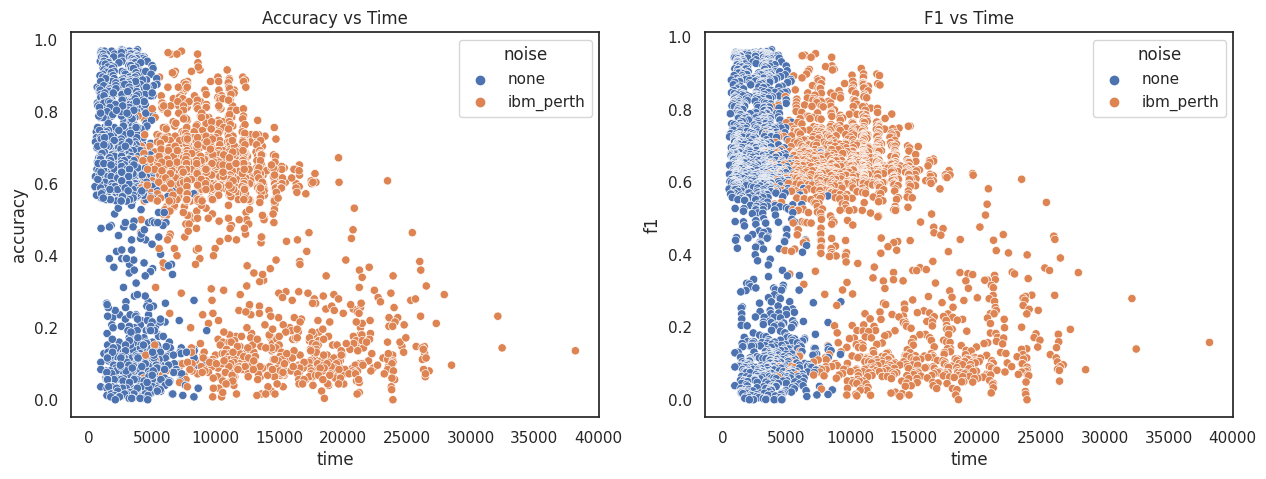

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=res, x='time', y='accuracy', hue='noise', ax=ax[0])
sns.scatterplot(data=res, x='time', y='f1', hue='noise', ax=ax[1])
ax[0].set_title('Accuracy vs Time')
ax[1].set_title('F1 vs Time')
plt.show()

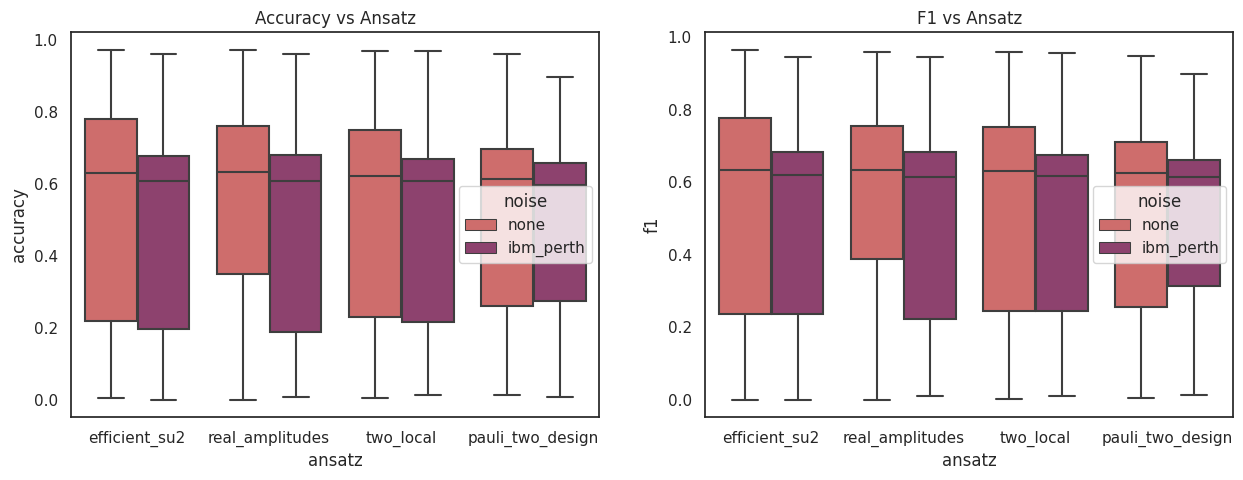

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=res, x='ansatz', y='accuracy', hue='noise', palette='flare', ax=ax[0])
sns.boxplot(data=res, x='ansatz', y='f1', hue='noise', palette='flare', ax=ax[1])
ax[0].set_title('Accuracy vs Ansatz')
ax[1].set_title('F1 vs Ansatz')
plt.show()

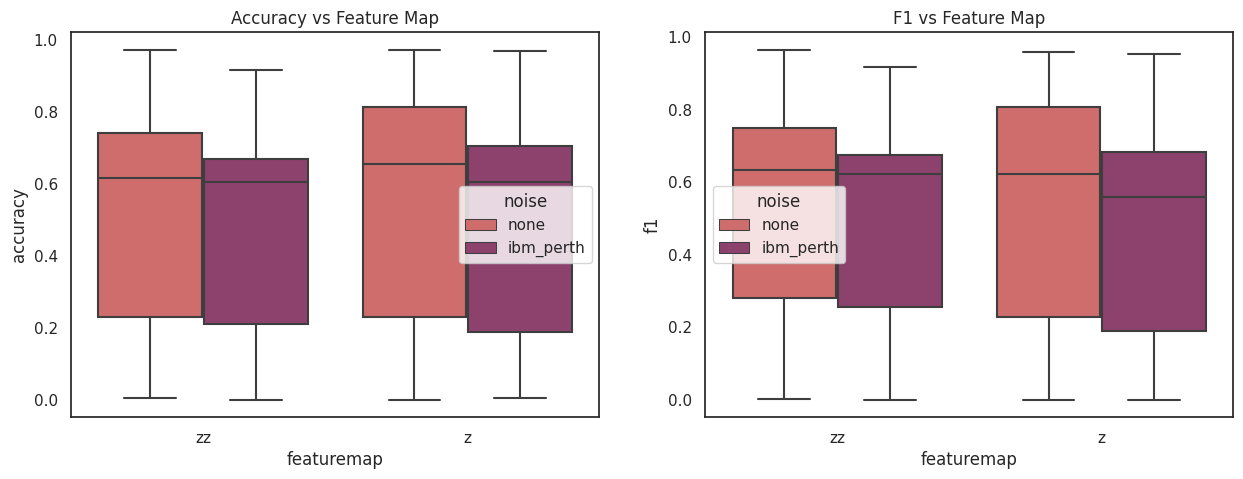

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=res, x='featuremap', y='accuracy', hue='noise', palette='flare', ax=ax[0])
sns.boxplot(data=res, x='featuremap', y='f1', hue='noise', palette='flare', ax=ax[1])
ax[0].set_title('Accuracy vs Feature Map')
ax[1].set_title('F1 vs Feature Map')
plt.show()

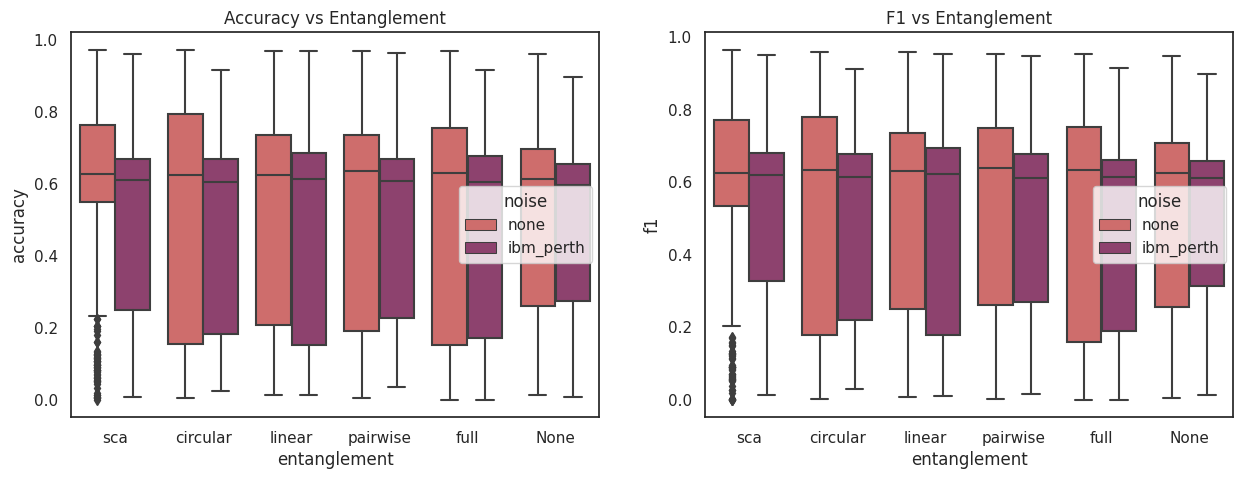

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
r = res.copy()
r.loc[r['entanglement'].isna(), 'entanglement'] = 'None'
sns.boxplot(data=r, x='entanglement', y='accuracy', hue='noise', palette='flare', ax=ax[0])
sns.boxplot(data=r, x='entanglement', y='f1', hue='noise', palette='flare', ax=ax[1])
ax[0].set_title('Accuracy vs Entanglement')
ax[1].set_title('F1 vs Entanglement')
plt.show()

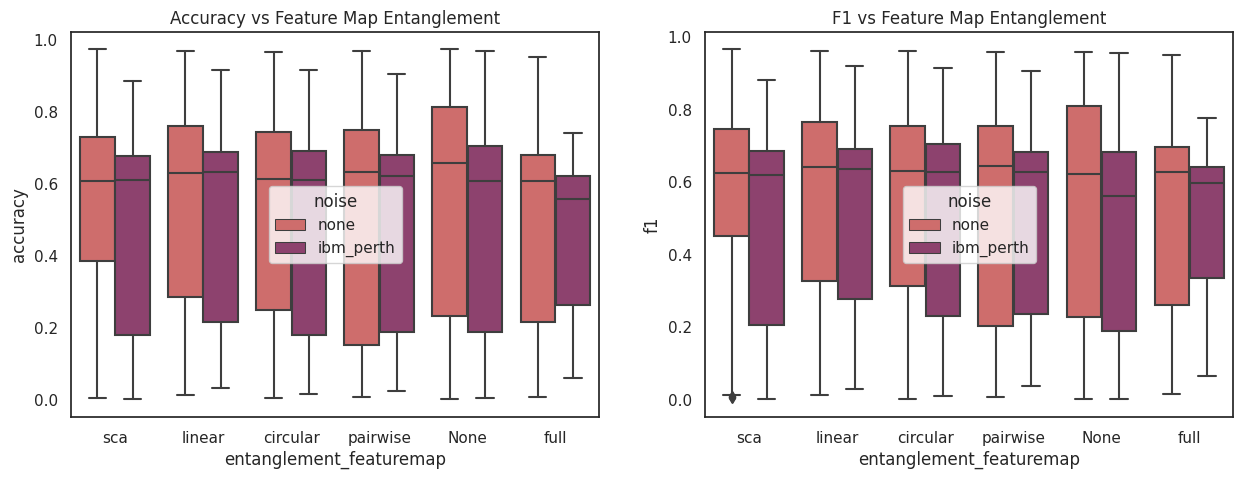

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
r = res.copy()
r.loc[r['entanglement_featuremap'].isna(), 'entanglement_featuremap'] = 'None'
sns.boxplot(data=r, x='entanglement_featuremap', y='accuracy', hue='noise', palette='flare', ax=ax[0])
sns.boxplot(data=r, x='entanglement_featuremap', y='f1', hue='noise', palette='flare', ax=ax[1])
ax[0].set_title('Accuracy vs Feature Map Entanglement')
ax[1].set_title('F1 vs Feature Map Entanglement')
plt.show()


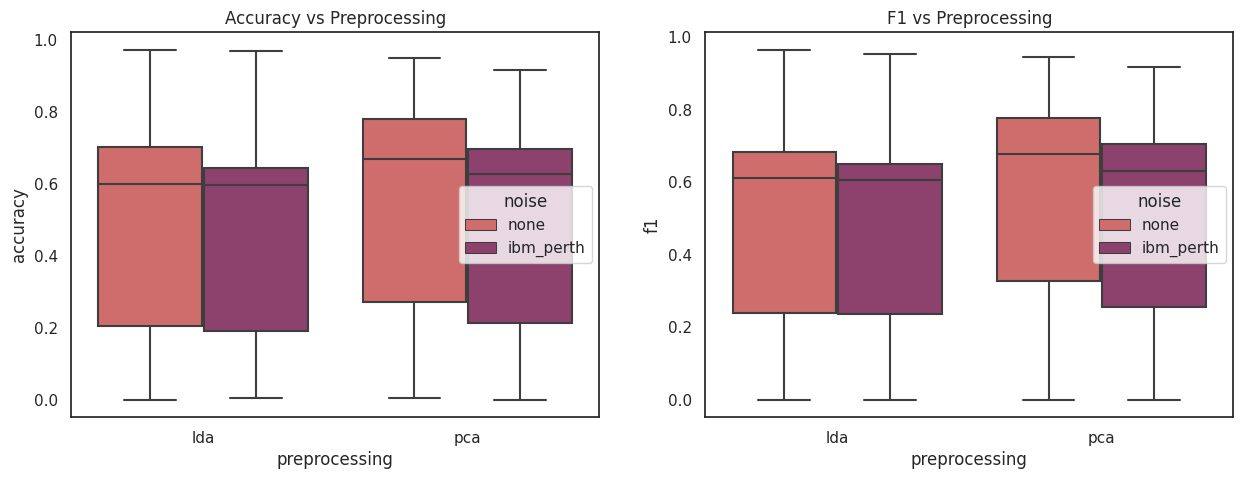

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=res, x='preprocessing', y='accuracy', hue='noise', palette='flare', ax=ax[0])
sns.boxplot(data=res, x='preprocessing', y='f1', hue='noise', palette='flare', ax=ax[1])
ax[0].set_title('Accuracy vs Preprocessing')
ax[1].set_title('F1 vs Preprocessing')
plt.show()

## Analyze Differences

In [90]:
diff.name = 'difference'
d = diff.reset_index()

In [91]:
diff

ansatz         featuremap  entanglement  entanglement_featuremap  preprocessing  optimizer    initialization
efficient_su2  z           circular      NaN                      lda            cobyla       beta              0.132
                                                                                              normal            0.032
                                                                                              uniform           0.064
                                                                                 nelder_mead  beta              0.008
                                                                                              normal            0.056
                                                                                                                ...  
two_local      zz          sca           sca                      pca            nelder_mead  normal            0.344
                                                                 

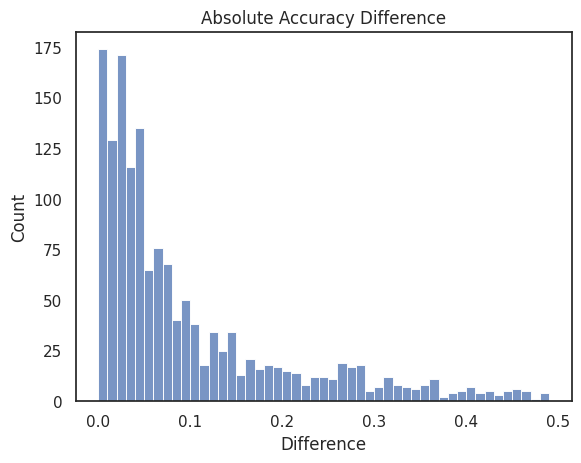

In [92]:
sns.histplot(d['difference'],bins=np.arange(0, 0.5, 0.01))
plt.title('Absolute Accuracy Difference')
plt.xlabel('Difference')
plt.ylabel('Count')
# plt.savefig("../reports/figures/kdd_absolute_differences.png", bbox_inches='tight')
plt.show()

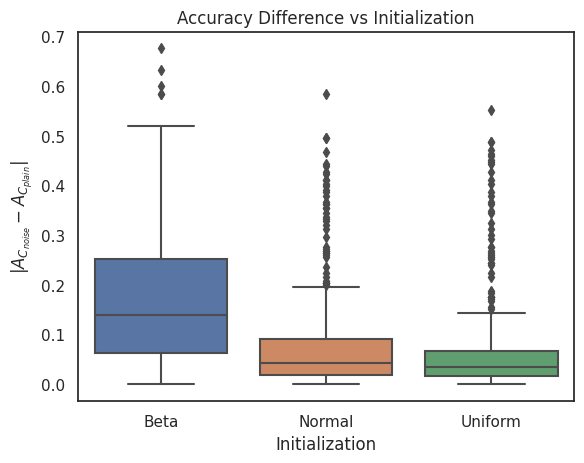

In [93]:
sns.boxplot(data=d, x='initialization', y='difference', palette='deep', order=['beta', 'normal', 'uniform'])
plt.title('Accuracy Difference vs Initialization')
plt.ylabel("$|A_{C_{noise}} - A_{C_{plain}}$|")
plt.xlabel("Initialization")
plt.xticks([0, 1, 2], ['Beta', 'Normal', 'Uniform'])
plt.savefig("../reports/figures/kdd_absolute_differences_initialization.png", bbox_inches='tight')
plt.show()


## Plot

In [94]:
d = diff.reset_index()
d

,ansatz,featuremap,entanglement,entanglement_featuremap,preprocessing,optimizer,initialization,difference
0,efficient_su2,z,circular,NaN,lda,cobyla,beta,0.132
1,efficient_su2,z,circular,NaN,lda,cobyla,normal,0.032
2,efficient_su2,z,circular,NaN,lda,cobyla,uniform,0.064
3,efficient_su2,z,circular,NaN,lda,nelder_mead,beta,0.008
4,efficient_su2,z,circular,NaN,lda,nelder_mead,normal,0.056
...,...,...,...,...,...,...,...,...
1507,two_local,zz,sca,sca,pca,nelder_mead,normal,0.344
1508,two_local,zz,sca,sca,pca,nelder_mead,uniform,0.488
1509,two_local,zz,sca,sca,pca,spsa,beta,0.028
1510,two_local,zz,sca,sca,pca,spsa,normal,0.028


In [95]:
diff.groupby(['initialization']).mean()

initialization
beta       0.165698
normal     0.076571
uniform    0.062841
Name: difference, dtype: float64